# Car Vs Ambulance classification using ensemble CNN


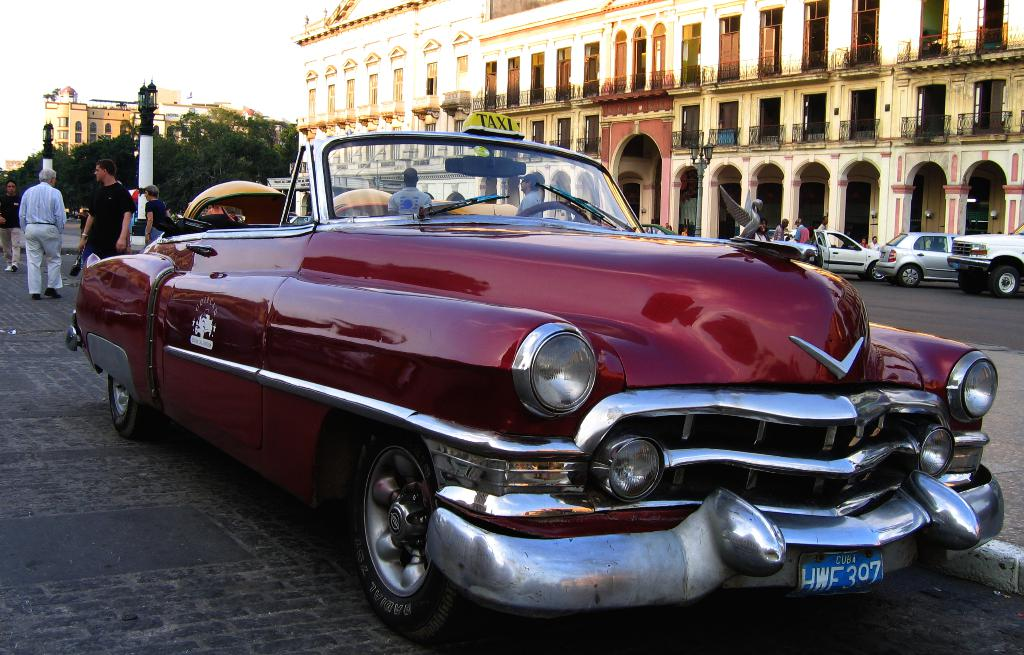

## 1. **Introduction**
Here’s a bullet-point description of the dataset:

### About Dataset
**Source of the Dataset** : [image-classification-and-yolo-dataset](https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data) \
**Classes**: Contains images of two primary classes: cars and ambulances. \
**Diversity**: Images include various angles, lighting conditions, and backgrounds.  \
**Labeling**: Each image is labeled for accurate classification and detection. \

**Applications**: \
**Image classification**: Identifying whether an image contains a car or an ambulance. \
**Object detection**: Locating and recognizing cars and ambulances within images. \
**Use Cases**: Ideal for projects such as traffic monitoring, emergency vehicle detection, and automated vehicle recognition systems. \
               Train file is for different types of Cars and Ambulances images. \
               Label file for the labels,which show the labels regarding about the images. 


## Planning
* Dataset also contain coordinates for each object in the image
* First I will try to work on only Object classification problem
* Then i will try to use those coordinates and make this problem as an Object detection

## 2. Data Preparation

In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import opendatasets as od
import random
import pathlib 
import os

tf.__version__

'2.17.0'

In [5]:
tf.config.list_physical_devices('GPU')

I0000 00:00:1726727483.779448   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726727483.786005   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726727483.787190   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
def download_datasets_from_kaggle(dataset_url:str, dataset_dir:str)-> None:
    # Dowload the dataset
    data_dir = pathlib.Path(dataset_dir)
    data_dir.mkdir(exist_ok=True)
    if os.path.isdir(dataset_dir):
        od.download(dataset_url, data_dir=data_dir)
    

In [7]:
# Dowload the dataset
dataset_url = 'https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data'
# Look into the data directory
dataset_dir = '../dataset'
download_datasets_from_kaggle(dataset_url=dataset_url, dataset_dir=dataset_dir)

Skipping, found downloaded files in "../dataset/image-classification-and-yolo-dataset" (use force=True to force download)


I. Quick look at the downloaded data

In [8]:
dataset_dir= dataset_dir + '/image-classification-and-yolo-dataset' + '/Ambulance_Car'
dataset_dir

'../dataset/image-classification-and-yolo-dataset/Ambulance_Car'

In [9]:
train_dir = dataset_dir + '/Train'
lables_dir = dataset_dir + '/Label'

In [10]:
len(os.listdir(train_dir)), len(os.listdir(lables_dir))

(1138, 1138)

II. Load data into the memory

In [11]:
import glob
import cv2

images = []
labels = []
IMAGE_SIZE = 224
for _image_path in glob.glob(train_dir+"/*.jpg"):
    _img = cv2.imread(filename=_image_path)
    _img = cv2.resize(_img, (IMAGE_SIZE,IMAGE_SIZE))
    # print(_image_path)
    file_name_without_ext = _image_path.split('/')[-1].split('.')[0]
    label_file = f'{lables_dir}/{file_name_without_ext}.txt'
    # print(label_file)
    with open(label_file, 'r') as _labels:
        for line in _labels.readlines():
            _label, x_min, y_min, x_max, y_max = line.split()
            labels.append(_label)
            images.append(_img)
            # print(_label)
              

In [12]:
len(images), len(labels)

(2784, 2784)

In [13]:
def plot_images_with_label(images, labels):
    random_nums = random.sample(range(0, len(images)), 6)
    for idx, rand_num in enumerate(random_nums):
        plt.subplot(3, 3, idx+1)
        plt.imshow(images[rand_num])
        plt.title(labels[rand_num])
        plt.axis('off')
    plt.show() 

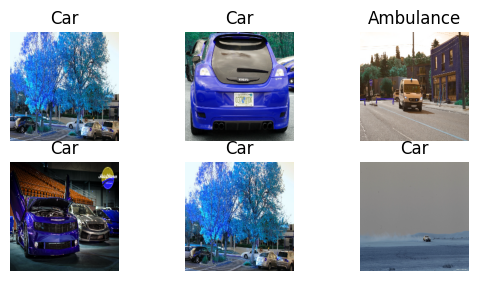

In [14]:
plot_images_with_label(images, labels)

### Data transforms (normalization & data augmentation)

Dataset split for training and testing

In [15]:
import numpy as np
images_arr = np.array(images)
labels_arr = np.array(labels)
images_arr.shape, labels_arr.shape

((2784, 224, 224, 3), (2784,))

In [16]:
images_arr[0]

array([[[ 84,  99,  98],
        [ 83,  95,  99],
        [ 87, 106, 103],
        ...,
        [ 55,  43,  33],
        [ 50,  37,  29],
        [ 48,  35,  27]],

       [[ 81, 102, 107],
        [ 93, 104, 113],
        [ 87,  99,  99],
        ...,
        [ 50,  38,  29],
        [ 49,  36,  28],
        [ 50,  37,  29]],

       [[ 88, 100, 100],
        [ 92, 106, 108],
        [ 90,  97, 100],
        ...,
        [ 50,  38,  32],
        [ 56,  40,  33],
        [ 54,  39,  33]],

       ...,

       [[ 38,  37,  33],
        [ 21,  20,  16],
        [  5,   5,   5],
        ...,
        [ 42,  40,  37],
        [ 46,  45,  41],
        [ 40,  40,  35]],

       [[  2,   1,   1],
        [ 15,  17,  14],
        [  9,   7,   7],
        ...,
        [ 40,  39,  36],
        [ 43,  43,  39],
        [ 42,  42,  36]],

       [[ 55,  49,  43],
        [ 30,  29,  28],
        [ 12,  12,  12],
        ...,
        [ 43,  43,  37],
        [ 39,  37,  36],
        [ 44,  44,  38]]

In [17]:
# Normalizing images
images_arr = images_arr/255.
images_arr[0]

array([[[0.32941176, 0.38823529, 0.38431373],
        [0.3254902 , 0.37254902, 0.38823529],
        [0.34117647, 0.41568627, 0.40392157],
        ...,
        [0.21568627, 0.16862745, 0.12941176],
        [0.19607843, 0.14509804, 0.11372549],
        [0.18823529, 0.1372549 , 0.10588235]],

       [[0.31764706, 0.4       , 0.41960784],
        [0.36470588, 0.40784314, 0.44313725],
        [0.34117647, 0.38823529, 0.38823529],
        ...,
        [0.19607843, 0.14901961, 0.11372549],
        [0.19215686, 0.14117647, 0.10980392],
        [0.19607843, 0.14509804, 0.11372549]],

       [[0.34509804, 0.39215686, 0.39215686],
        [0.36078431, 0.41568627, 0.42352941],
        [0.35294118, 0.38039216, 0.39215686],
        ...,
        [0.19607843, 0.14901961, 0.1254902 ],
        [0.21960784, 0.15686275, 0.12941176],
        [0.21176471, 0.15294118, 0.12941176]],

       ...,

       [[0.14901961, 0.14509804, 0.12941176],
        [0.08235294, 0.07843137, 0.0627451 ],
        [0.01960784, 0

In [18]:
labels_arr[:5]

array(['Car', 'Car', 'Car', 'Car', 'Car'], dtype='<U9')

In [49]:
from sklearn.calibration import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_arr)
label_names =list(label_encoder.classes_)
encoded_labels[:5], label_names

(array([1, 1, 1, 1, 1]), ['Ambulance', 'Car'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, encoded_labels, test_size=0.2, shuffle=True, random_state=42) 
len(X_train), len(X_test)

(2227, 557)

In [22]:
#  Convert the split data into TensorFlow datasets
BATCH_SIZE=32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Prefetch to optimize performance
train_dataset_prefetch = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_prefech = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1726727489.601280   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726727489.607030   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726727489.611162   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726727489.731528   28272 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [66]:
for elem in train_dataset_prefetch.take(1):
    print(elem[0])
    break

2024-09-19 07:00:58.705823: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2681806848 exceeds 10% of free system memory.


tf.Tensor(
[[[[0.16078431 0.11764706 0.08627451]
   [0.16470588 0.1254902  0.09019608]
   [0.16862745 0.12941176 0.09019608]
   ...
   [0.94901961 0.8745098  0.84705882]
   [0.95686275 0.88235294 0.85490196]
   [0.96078431 0.88627451 0.85882353]]

  [[0.18823529 0.14901961 0.10980392]
   [0.18039216 0.1372549  0.10196078]
   [0.17647059 0.1372549  0.09803922]
   ...
   [0.94117647 0.86666667 0.83529412]
   [0.9372549  0.8627451  0.83529412]
   [0.94509804 0.87058824 0.84313725]]

  [[0.16862745 0.1254902  0.09411765]
   [0.19607843 0.15294118 0.11764706]
   [0.20392157 0.16470588 0.11764706]
   ...
   [0.94117647 0.86666667 0.83529412]
   [0.94509804 0.87058824 0.83921569]
   [0.94117647 0.86666667 0.83529412]]

  ...

  [[0.1254902  0.18823529 0.28627451]
   [0.30196078 0.42745098 0.54117647]
   [0.22745098 0.37254902 0.49803922]
   ...
   [0.34901961 0.45882353 0.55294118]
   [0.17647059 0.21960784 0.2745098 ]
   [0.05098039 0.0745098  0.10196078]]

  [[0.42745098 0.56470588 0.666666

## Model 1 - MiniVGGNet

### MiniVGGNet Build

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Input

In [27]:

class MiniVGGNet:
    @staticmethod
    def build(width:int, height:int, depth:int):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself

        inputShape = (height, width, depth)
        chanDim = -1

        return Sequential([
            Input(shape=inputShape),
            # first CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # second CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # first (and only) set of FC => RELU layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),

            # softmax classifier
            Dense(1, activation='sigmoid')

        ])

In [28]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
mini_vggnet_model = MiniVGGNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
mini_vggnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,829,857 (392.26 MB)

 Trainable params: 102,828,449 (392.26 MB)

 Non-trainable params: 1,408 (5.50 KB)

### MiniVGGNet Train

In [29]:

mini_vggnet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "precision", "recall"])

# train the network
mini_vggnet_history = mini_vggnet_model.fit(train_dataset_prefetch,
              validation_data=val_dataset_prefech,
              batch_size=BATCH_SIZE,
              epochs=20,
              verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6990 - loss: 0.7422 - val_accuracy: 0.8133 - val_loss: 0.5306
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8569 - loss: 0.3713 - val_accuracy: 0.8923 - val_loss: 0.3760
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8808 - loss: 0.3239 - val_accuracy: 0.8743 - val_loss: 0.4273
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9115 - loss: 0.2672 - val_accuracy: 0.9120 - val_loss: 0.3036
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9438 - loss: 0.1802 - val_accuracy: 0.8797 - val_loss: 0.5370
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9449 - loss: 0.1718 - val_accuracy: 0.9336 - val_loss: 0.2752
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9530 - loss: 0.1361 - val_accuracy: 0.9013 - val_loss: 0.4456
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9647 - loss: 0.1216 - val_accuracy: 0.9282 - v

In [30]:
tf.keras.backend.clear_session()

### MiniVGGNet Evaluate

In [67]:
def predict(model):
    predictions = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred =  (predictions > 0.5).astype(int)
    return y_pred

In [44]:
# evaluate the network
mini_vggnet_y_pred = predict(mini_vggnet_model)
mini_vggnet_y_pred[:5]

NameError: name 'mini_vggnet_model' is not defined

In [ ]:
mini_vggnet_report = classification_report(y_test, mini_vggnet_y_pred, target_names=label_names)
print(mini_vggnet_report)

### MiniVGGNet Results Plot

In [32]:
# Plot accuracies
def plot_accuracies(history):
    train_accuracy = history.history['accuracy'] 
    val_accuracy = history.history['val_accuracy'] 
    plt.plot(np.arange(0, 20), train_accuracy, '-x', label='train_accuracy')
    plt.plot(np.arange(0, 20), val_accuracy, '-x', label='val_accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'])
    plt.ylabel('train_accuracy/val_accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = history.history['loss']
    val_losses =history.history['val_loss']
    plt.plot(np.arange(0, 20),train_losses, '-bx', label='train_losses')
    plt.plot(np.arange(0, 20),val_losses, '-rx', label='val_losses')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.title('Loss vs. No. of epochs')

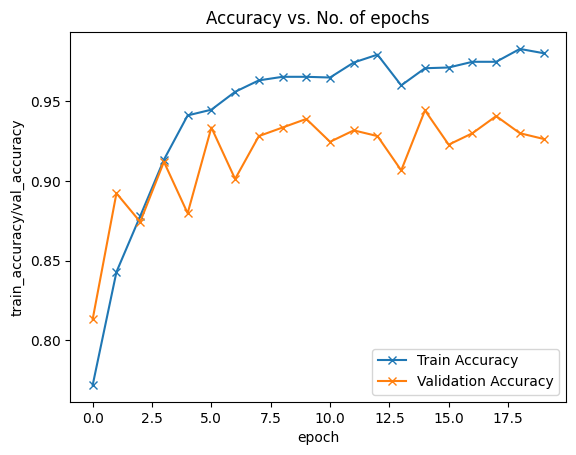

In [82]:
plot_accuracies(mini_vggnet_history)

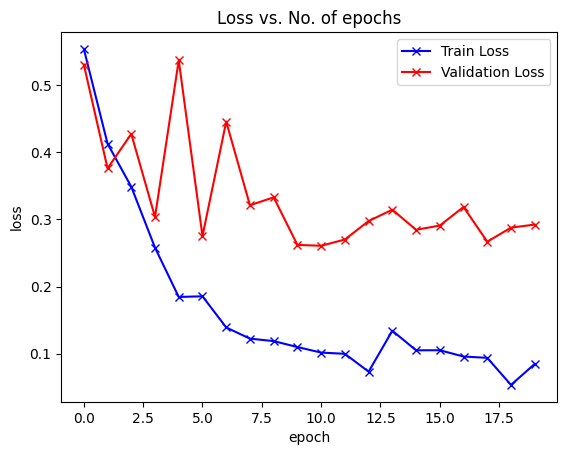

In [78]:
plot_losses(mini_vggnet_history)

## Model 2 - LeNet

### LeNet Build

In [28]:
class LeNet:
    @staticmethod
    def build(width:int, height:int, depth:int):
        inputShape = (height, width, depth)
        
        # initialize the model
        return Sequential([
            Input(shape=inputShape),
            # first set of CONV => RELU => POOL layers
            Conv2D(20, (5, 5), padding='same',  activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.25),
            
            # second set of CONV => RELU => POOL layers
            Conv2D(50, (5, 5), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.25),

            Flatten(),
            Dropout(0.5),
            Dense(500, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid'),
        ])

In [29]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
Lenet_model = LeNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
Lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 50)   │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │    78,400,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,427,571 (299.18 MB)

 Trainable params: 78,427,571 (299.18 MB)

 Non-trainable params: 0 (0.00 B)

### LeNet Train

In [30]:

Lenet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "precision", "recall"])

# train the network
Lenet_model_history = Lenet_model.fit(train_dataset_prefetch,
              validation_data=val_dataset_prefech,
              batch_size=BATCH_SIZE,
              epochs=20,
              verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8342 - loss: 0.4604 - precision: 0.8607 - recall: 0.9620 - val_accuracy: 0.8618 - val_loss: 0.4188 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8288 - loss: 0.4442 - precision: 0.8297 - recall: 0.9983 - val_accuracy: 0.8618 - val_loss: 0.3705 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8351 - loss: 0.4120 - precision: 0.8402 - recall: 0.9888 - val_accuracy: 0.8761 - val_loss: 0.3157 - val_precision: 0.8813 - val_recall: 0.9896
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8655 - loss: 0.3456 - precision: 0.8772 - recall: 0.9770 - val_accuracy: 0.8887 - val_loss: 0.2883 - val_precision: 0.8973 - val_recall: 0.9833
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8835 - loss: 0.3049 - precision: 0.9004 - recall: 0.9685 - val_accuracy: 0.8941 - val_loss: 0.2770 

### LeNet Evaluate

In [ ]:
# evaluate the network
letnet_y_pred = predict(Lenet_model)
letnet_y_pred[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[1],
       [1],
       [1],
       [1],
       [0]])

In [ ]:
letnet_report = classification_report(y_test, letnet_y_pred, target_names=label_names)
print(letnet_report)

### LeNet Result Plot

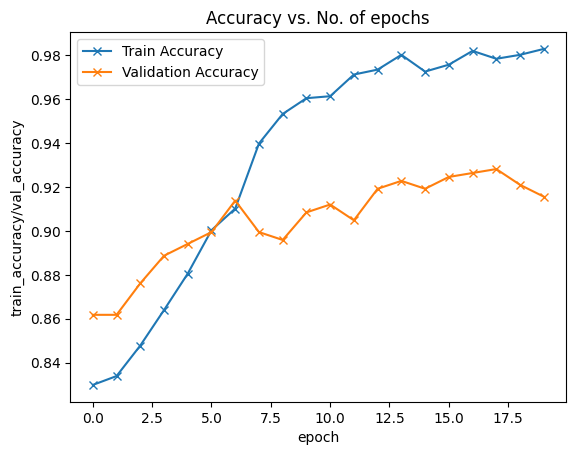

In [33]:
plot_accuracies(Lenet_model_history)

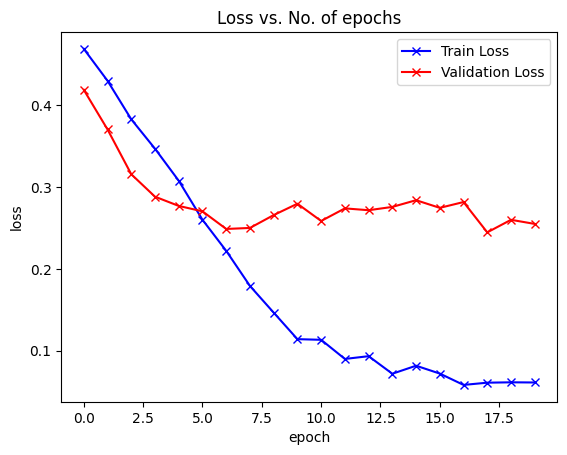

In [34]:
plot_losses(Lenet_model_history)

## Model 3 - Shallownet

### Shallownet Build

In [36]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # channels last
        input_shape = (height, width, depth)


        # define the first and only CONV => RELU layer
        model = Sequential(
            [
                Input(shape=input_shape),
                Conv2D(32, (3, 3),
                       padding="same",  activation='relu'),
                Flatten(),
                Dense(1, activation='sigmoid'),
            ]
        )
        return model

In [37]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
shallownet_model = ShallowNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
shallownet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1605632)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │     1,605,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,606,529 (6.13 MB)

 Trainable params: 1,606,529 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

### Shallownet Train

In [38]:

shallownet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "precision", "recall"])

# train the network
shallownet_model_history = shallownet_model.fit(train_dataset_prefetch,
              validation_data=val_dataset_prefech,
              batch_size=BATCH_SIZE,
              epochs=20,
              verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7870 - loss: 3.7012 - precision: 0.8355 - recall: 0.9305 - val_accuracy: 0.8618 - val_loss: 0.3512 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8673 - loss: 0.3532 - precision: 0.8744 - recall: 0.9846 - val_accuracy: 0.9102 - val_loss: 0.2869 - val_precision: 0.9424 - val_recall: 0.9542
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9086 - loss: 0.2339 - precision: 0.9204 - recall: 0.9756 - val_accuracy: 0.9031 - val_loss: 0.2747 - val_precision: 0.9475 - val_recall: 0.9396
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9690 - loss: 0.1108 - precision: 0.9725 - recall: 0.9907 - val_accuracy: 0.9228 - val_loss: 0.2454 - val_precision: 0.9259 - val_recall: 0.9896
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9754 - loss: 0.0927 - precision: 0.9778 - recall: 0.9933 - val_accuracy: 0.9156 - val_loss: 0.2664 

### Shallownet Evaluate

In [68]:
# evaluate the network
shallownet_y_pred = predict(shallownet_model)
shallownet_y_pred[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[1],
       [1],
       [1],
       [1],
       [0]])

In [65]:
shallownet_report = classification_report(y_test, shallownet_y_pred, target_names=label_names)
print(shallownet_report)

              precision    recall  f1-score   support

   Ambulance       0.79      0.49      0.61        77
         Car       0.92      0.98      0.95       480

    accuracy                           0.91       557
   macro avg       0.86      0.74      0.78       557
weighted avg       0.91      0.91      0.90       557



### Shallownet Result Plot

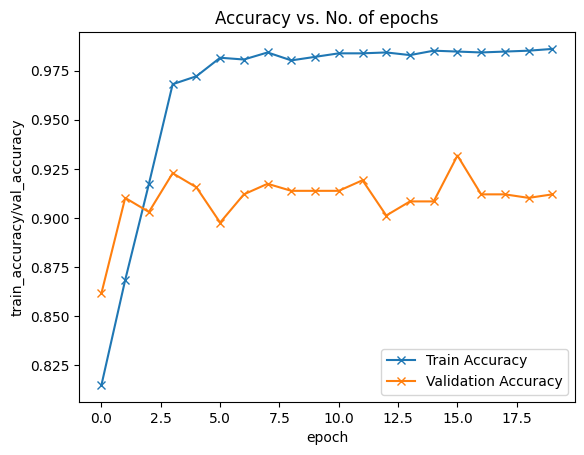

In [41]:
plot_accuracies(shallownet_model_history)

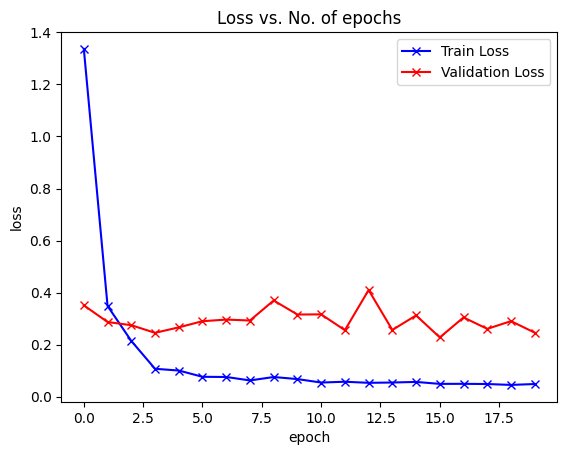

In [42]:
plot_losses(shallownet_model_history)